# Find suitable detector params for each parking

In [1]:
import random
import numpy
from datetime import datetime
from src.data.ParkingProvider import NoSpacesException, NoImageException
from src.metrics.PerformanceMetricsProviderSklearn import PerformanceMetricsProviderSklearn
from src.metrics.entity.PerformanceMetrics import PerformanceMetrics
from src.detector.entity.DetectionParams import DetectionParams
from src.data.ParkingProviderLocal import ParkingProviderLocalParams,ParkingProviderLocal
from src.data.ParkingProviderLocalSqlite import ParkingProviderLocalSqlite, ParkingProviderLocalSqliteParams
from src.data.ParkingProviderSqlite import ParkingProviderSqlite, ParkingProviderSqliteParams

from src.app.ParkingOccupancyProcessorLocal import ParkingOccupancyProcessorLocal
from src.app.ParkingOccupancyProcessorLocalSqlite import ParkingOccupancyProcessorLocalSqlite
from src.app.ParkingOccupancyProcessorSqlite import ParkingOccupancyProcessorSqlite


from src.detector.OccupancyDetectorBorders import OccupancyDetectorBorders
import cv2 as cv

metrics_list = list()
row_names = list()
random_seed = datetime.now().timestamp

def test_parking(parking_id, detection_params:DetectionParams, row_name, local_provider=True, process_batch=False):
    metrics_provider: PerformanceMetricsProviderSklearn = PerformanceMetricsProviderSklearn()

    if local_provider:
        provider_params = ParkingProviderLocalParams(
        parking_id=parking_id, path='E:\\Documents\\PKLot\\PKLot\\PKLot\\PKLot\\'+parking_id, k=20, random_seed=random_seed)
        processor = ParkingOccupancyProcessorLocal(
        parking_provider_params=provider_params, detection_params=detection_params, performance_metrics_provider=metrics_provider)

    
    else:
        # provider_params = ParkingProviderLocalSqliteParams(
        # parking_id=parking_id, path='E:\\Documents\\PKLot\\PKLot\\PKLot\\PKLot\\'+parking_id, k=4, random_seed=random_seed,db_file ='E:/OneDrive - UNIVERSIDAD DE HUELVA\TFG\VisionParkWeb-main\VisionParkWeb\VisionParkWeb\db.sqlite3')
        # processor = ParkingOccupancyProcessorLocalSqlite(
        # parking_provider_params=provider_params, detection_params=detection_params, performance_metrics_provider=metrics_provider)

        provider_params = ParkingProviderSqliteParams( parking_id=parking_id, db_file ='E:/OneDrive - UNIVERSIDAD DE HUELVA\TFG\VisionParkWeb-main\VisionParkWeb\VisionParkWeb\db.sqlite3')
        processor = ParkingOccupancyProcessorSqlite(
        parking_provider_params=provider_params, detection_params=detection_params, performance_metrics_provider=metrics_provider)

    
    
    if process_batch:
        try:
            detection_params.show_imshow=False
            processor.process_batch()
        except (NoSpacesException, NoImageException) as ex:
            print(f"Finished processing samples: ", ex)

    else:
        while True:
            try:
                processor.process()
                if not local_provider:
                    break
            except (NoSpacesException, NoImageException) as ex:
                print(f"Finished processing samples: ", ex)
                break
       
    if local_provider:
        metrics_provider.calculate_metrics()
        metrics_provider.show_confusion_matrix()

        metrics_list.append(metrics_provider.metrics)
        row_names.append(row_name)
    
def setup_params(parking_id, initial_params:DetectionParams=None):
    img_empty = cv.imread(f"E:\OneDrive - UNIVERSIDAD DE HUELVA\TFG\VisionParkDetect\dataset\{parking_id}_empty.jpg", cv.IMREAD_GRAYSCALE)
    
    provider_params = ParkingProviderLocalParams(
        parking_id=parking_id, path='E:\\Documents\\PKLot\\PKLot\\PKLot\\PKLot\\'+parking_id, k=200)

    parking_provider = ParkingProviderLocal(provider_params)

    # metrics: PerformanceMetricsProviderSklearn = PerformanceMetricsProviderSklearn()

    # processor = ParkingOccupancyProcessorLocal(
    #     parking_provider_params=provider_params, detection_params=PARAMS_UFPR04, performance_metrics_provider=metrics)

    try:
        params = initial_params
        while True:
        # while (it > 0 and i < it) or it < 0:
        #     i = i+1
        #     print(f"Processing sample: {str(i)}")
        #     processor.process()

            parking = parking_provider.get_parking()
            img = parking.image
            spaces = parking.spaces

            params = OccupancyDetectorBorders.setup_params_img(img, spaces, params, img_empty)

            
            cv.namedWindow("Press ESC to exit, other key to continue")
            key = cv.waitKey(0)
            if key == 27:
                cv.destroyAllWindows()
                break  
              
            cv.destroyAllWindows()
   
    except (NoSpacesException, NoImageException) as ex:
        print(f"Finished processing: ", ex)
    finally:
        return params
    

In [7]:
PARAMS_UFPR04 = DetectionParams((3, 3), 0, cv.ADAPTIVE_THRESH_GAUSSIAN_C, at_blockSize=31, at_C=10, median_k=3, bw_size=80, vacant_threshold=0.05, show_imshow=True)  # UFPR04
PARAMS_UFPR04.bf_d = None
PARAMS_UFPR04.diff_threshold = 60
PARAMS_UFPR04.parking_id = 'UFPR04'

test_parking('UFPR04', PARAMS_UFPR04, 'UFPR04 GaussianBlur',local_provider=True, process_batch=False)

Selected 947 files


KeyboardInterrupt: 

## UFPR04

In [3]:
PARAMS_UFPR04 = DetectionParams((3,3), 0, cv.ADAPTIVE_THRESH_GAUSSIAN_C, at_blockSize=31, at_C=10, median_k=5, bw_size=150, vacant_threshold=0.23, show_imshow=True)  # UFPR04

p = setup_params('UFPR04',PARAMS_UFPR04)
p.show_imshow=True
print(p)

Selected 18 files
DetectionParams
gb_k: (3, 3)
gb_s: 0
at_method: 1
at_blockSize: 31
at_C: 10
median_k: 5
bw_size: 150
bw_conn: 8
channel: v
vacant_threshold: 0.3
show_imshow: True

DetectionParams(gb_k=(3, 3), gb_s=0, at_method=cv.ADAPTIVE_THRESH_GAUSSIAN_C, at_blockSize=31, at_C=10, median_k=5, bw_size=150, vacant_threshold=0.3, show_imshow=True)


Selected 947 files
Finished processing samples:  Finished fetching path
Precision: 0.913
specificity: 0.893
Recall: 0.822
F1 Score: 0.865
Accuracy: 0.852


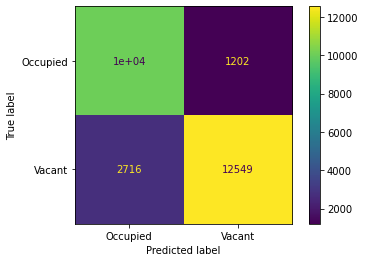

In [40]:
PARAMS_UFPR04 = DetectionParams((9, 9), 0, cv.ADAPTIVE_THRESH_GAUSSIAN_C, at_blockSize=31, at_C=10, median_k=3, bw_size=50, vacant_threshold=0.23, show_imshow=True)  # UFPR04
PARAMS_UFPR04.bf_d = None
test_parking('UFPR04', PARAMS_UFPR04, 'UFPR04 GaussianBlur',local_provider=True, process_batch=False)

#### With web app segmentation

In [19]:
PARAMS_UFPR04 = DetectionParams((3,3), 0, cv.ADAPTIVE_THRESH_GAUSSIAN_C, at_blockSize=31, at_C=10, median_k=3, bw_size=150, vacant_threshold=0.12, show_imshow=True)  # UFPR04
PARAMS_UFPR04.bf_d = None
test_parking('UFPR04', PARAMS_UFPR04, 'UFPR04',local_provider=False, process_batch=False)

## UFPR05

Selected 1038 files
Processing 1038 files with 16 workers


100%|██████████| 1038/1038 [02:07<00:00,  8.12it/s]


Precision: 0.882
specificity: 0.929
Recall: 0.761
F1 Score: 0.817
Accuracy: 0.860


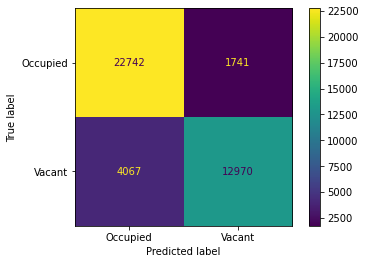

In [3]:
PARAMS_UFPR04 = DetectionParams((3,3), 0, cv.ADAPTIVE_THRESH_GAUSSIAN_C, at_blockSize=31, at_C=10, median_k=3, bw_size=150, vacant_threshold=0.12, show_imshow=True)  # UFPR04
PARAMS_UFPR05 = DetectionParams(gb_k=(3,3), gb_s=0, at_method=cv.ADAPTIVE_THRESH_GAUSSIAN_C, at_blockSize=33, at_C=9, median_k=3, bw_size=20, vacant_threshold=0.26, show_imshow=False)
# PARAMS_UFPR05.bf_d = 4
# PARAMS_UFPR05.bf_sigma_color = 60
# PARAMS_UFPR05.bf_sigma_space = 60
# p = setup_params('UFPR05', PARAMS_UFPR05)
# p.show_imshow=True
# print(p)

test_parking('UFPR05', PARAMS_UFPR05, 'UFPR05',local_provider=True, process_batch=True)


In [39]:
PARAMS_UFPR05 = DetectionParams(gb_k=None, gb_s=0, at_method=cv.ADAPTIVE_THRESH_GAUSSIAN_C, at_blockSize=33, at_C=9, median_k=3, bw_size=20, vacant_threshold=0.2, show_imshow=True)
# PARAMS_UFPR05.bf_d = 4
# PARAMS_UFPR05.bf_sigma_color = 60
# PARAMS_UFPR05.bf_sigma_space = 60
# p = setup_params('UFPR05', PARAMS_UFPR05)
# p.show_imshow=True
# print(p)

test_parking('UFPR05', PARAMS_UFPR05, 'UFPR05',local_provider=True, process_batch=False)

In [ ]:
# p = setup_params('UFPR05', PARAMS_UFPR05)
# p.show_imshow=True
# print(p)

PARAMS_UFPR05 = DetectionParams(gb_k=(5, 5), gb_s=0, at_method=cv.ADAPTIVE_THRESH_GAUSSIAN_C, at_blockSize=33, at_C=7, median_k=3, bw_size=85, vacant_threshold=0.3, show_imshow=True)
test_parking('UFPR05', PARAMS_UFPR05, 'UFPR05 params 2', process_batch=True)

In [ ]:
PARAMS_UFPR05 = DetectionParams(gb_k=(5, 5), gb_s=0, at_method=cv.ADAPTIVE_THRESH_GAUSSIAN_C, at_blockSize=33, at_C=9, median_k=3, bw_size=300, vacant_threshold=0.22, show_imshow=True)
# p = setup_params('UFPR05', PARAMS_UFPR05)
# p.show_imshow=True
# print(p)

test_parking('UFPR05', PARAMS_UFPR05, 'UFPR05 params 3', process_batch=True)

In [ ]:
PerformanceMetricsProviderSklearn.show_dataframe(metrics_list, row_names)


#### With web app segmentation

In [27]:
PARAMS_UFPR05 = DetectionParams(gb_k=(5, 5), gb_s=0, at_method=cv.ADAPTIVE_THRESH_GAUSSIAN_C, at_blockSize=33, at_C=9, median_k=3, bw_size=300, vacant_threshold=0.12, show_imshow=True)
PARAMS_UFPR05.bf_d = None
test_parking('UFPR05', PARAMS_UFPR05, 'UFPR05',local_provider=False, process_batch=False)

## PUCPR

In [28]:
PARAMS_UFPR05 = DetectionParams(gb_k=(5, 5), gb_s=0, at_method=cv.ADAPTIVE_THRESH_GAUSSIAN_C, at_blockSize=33, at_C=9, median_k=3, bw_size=300, vacant_threshold=0.12, show_imshow=True)

p = setup_params('PUCPR', PARAMS_UFPR05)
p.show_imshow=True
print(p)

Selected 22 files
DetectionParams
gb_k: (5, 5)
gb_s: 0
at_method: 1
at_blockSize: 33
at_C: 9
median_k: 3
bw_size: 300
bw_conn: 8
channel: v
vacant_threshold: 0.3
show_imshow: True

DetectionParams(gb_k=(5, 5), gb_s=0, at_method=cv.ADAPTIVE_THRESH_GAUSSIAN_C, at_blockSize=33, at_C=9, median_k=3, bw_size=300, vacant_threshold=0.3, show_imshow=True)


Selected 1118 files
Processing 1118 files with 16 workers


100%|██████████| 1118/1118 [02:56<00:00,  6.32it/s]


Precision: 0.909
specificity: 0.905
Recall: 0.920
F1 Score: 0.915
Accuracy: 0.913


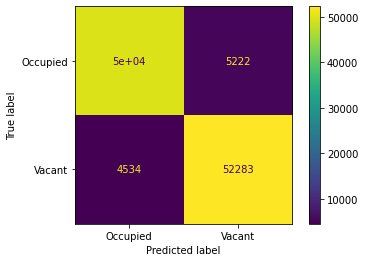

In [4]:
PARAMS_PUCPR = DetectionParams(gb_k=(5, 5), gb_s=0, at_method=cv.ADAPTIVE_THRESH_GAUSSIAN_C, at_blockSize=27, at_C=7, median_k=3, bw_size=85, vacant_threshold=0.28, show_imshow=True)
# p = setup_params('UFPR05', PARAMS_UFPR05)
# p.show_imshow=True
# print(p)

test_parking('PUCPR', PARAMS_PUCPR, 'PUCPR', process_batch=True)

In [36]:
PARAMS_PUCPR = DetectionParams(gb_k=(5, 5), gb_s=0, at_method=cv.ADAPTIVE_THRESH_GAUSSIAN_C, at_blockSize=27, at_C=7, median_k=3, bw_size=85, vacant_threshold=0.28, show_imshow=True)
# p = setup_params('UFPR05', PARAMS_UFPR05)
# p.show_imshow=True
# print(p)

test_parking('PUCPR', PARAMS_PUCPR, 'PUCPR', process_batch=False, local_provider=False)

In [11]:
PARAMS_PUCPR = DetectionParams(gb_k=(5, 5), gb_s=0, at_method=cv.ADAPTIVE_THRESH_GAUSSIAN_C, at_blockSize=27, at_C=7, median_k=3, bw_size=85, vacant_threshold=0.2, show_imshow=True)
# p = setup_params('UFPR05', PARAMS_UFPR05)
# p.show_imshow=True
# print(p)

test_parking('PUCPR', PARAMS_PUCPR, 'PUCPR', process_batch=False, local_provider=False)

In [ ]:
# Step by step detection
gaussianBlurKernel = (3, 3)  # Tamaño kernel suavizado gaussiano
gaussianBlurSigma = 0
at_blockSize = 41           # Tamaño vecindad umbral adaptativo
at_C = 11                    # Constante a sustraer en el umbral adaptativo
median_k = 3                # Tamaño kernel filtro mediana
bw_size = 104                # Umbral Eliminar objetos pequeños
params = DetectionParams(gaussianBlurKernel, gaussianBlurSigma,
                         cv.ADAPTIVE_THRESH_GAUSSIAN_C, at_blockSize, at_C, median_k, bw_size, vacant_threshold=0.25, show_imshow=False)  # UFPR04

confusion_matrix = detect_batch(selected_files, params)

## UPR05

In [ ]:
from ipynb.fs.full.ParkingSpaceDetector import *
import random
import glob

# params = DetectionParams((5,5), 0, cv.ADAPTIVE_THRESH_GAUSSIAN_C, 33, 7, 3, 85) # UPR05
path = 'E:\\Documents\\PKLot\\PKLot\\PKLot\\PKLot\\UFPR05'
files = glob.glob(path+ '/**/*.jpg', recursive=True)            # Get all images in path
selected_files = random.choices(files, k=int(len(files)/10))    # Select n random images from dataset

In [ ]:
import numpy as np
parking_id = 'UFPR04'
provider_params = ParkingProviderLocalParams(
    parking_id=parking_id, path='E:\\Documents\\PKLot\\PKLot\\PKLot\\PKLot\\'+parking_id, k=4, random_seed=random_seed)

provider = ParkingProviderLocal(provider_params)


img = provider.fetch_image()[0]
imgGray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

# Create trackbars for adjusting threshold values
cv.namedWindow("Trackbars")
cv.createTrackbar("1-Low Threshold", "Trackbars", 0, 255, lambda x: None)
cv.createTrackbar("1-High Threshold", "Trackbars", 0, 1000, lambda x: None)
cv.createTrackbar("d", "Trackbars", 0, 255, lambda x: None)
cv.createTrackbar("sigma color", "Trackbars", 0, 1000, lambda x: None)
cv.createTrackbar("sigma space", "Trackbars", 0, 1000, lambda x: None)

while True:

    # Get the current values of the trackbars
    lowThreshold = cv.getTrackbarPos("1-Low Threshold", "Trackbars")
    highThreshold = cv.getTrackbarPos("1-High Threshold", "Trackbars")
    d = cv.getTrackbarPos("d", "Trackbars")
    sc = cv.getTrackbarPos("sigma color", "Trackbars")
    ss = cv.getTrackbarPos("sigma space", "Trackbars")

    # Bilateral filter
    imgBlur = cv.bilateralFilter(imgGray, d, sc, ss)

    # Apply Canny edge detection
    imgEdges = cv.Canny(imgBlur, lowThreshold, highThreshold)

    # Show the resulting image
    cv.imshow('Img', imgGray)
    cv.imshow('Img Blur', imgBlur)
    cv.imshow("Edges", imgEdges)

    # Wait for user input, and exit if the user presses the "q" key
    key = cv.waitKey(1)
    if key == ord("q"):
        # # Use Hough transform to detect lines in the edge map
        # lines = cv.HoughLinesP(imgEdges, 1, np.pi/180, 100, minLineLength=100, maxLineGap=10)
        # print(lines)
        
        provider.index += 1
        img = provider.fetch_image()[0]
        imgGray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        print('q')
        
        continue
    elif key == 27:
        cv.destroyAllWindows()
        break
    
    elif key == ord('d'):
        
        OccupancyDetectorBorders



In [6]:
import numpy as np
parking_id = 'UFPR04'
provider_params = ParkingProviderLocalParams(
    parking_id=parking_id, path='E:\\Documents\\PKLot\\PKLot\\PKLot\\PKLot\\'+parking_id, k=4, random_seed=random_seed)

provider = ParkingProviderLocal(provider_params)


img = provider.fetch_image()[0]
imgGray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

# Create trackbars for adjusting threshold values
cv.namedWindow("Trackbars")
cv.createTrackbar("1-Low Threshold", "Trackbars", 0, 255, lambda x: None)
cv.createTrackbar("1-High Threshold", "Trackbars", 0, 1000, lambda x: None)
cv.createTrackbar("d", "Trackbars", 0, 255, lambda x: None)
cv.createTrackbar("sigma color", "Trackbars", 0, 1000, lambda x: None)
cv.createTrackbar("sigma space", "Trackbars", 0, 1000, lambda x: None)

while True:

    # Get the current values of the trackbars
    lowThreshold = cv.getTrackbarPos("1-Low Threshold", "Trackbars")
    highThreshold = cv.getTrackbarPos("1-High Threshold", "Trackbars")
    d = cv.getTrackbarPos("d", "Trackbars")
    sc = cv.getTrackbarPos("sigma color", "Trackbars")
    ss = cv.getTrackbarPos("sigma space", "Trackbars")

    # Bilateral filter
    imgBlur = cv.bilateralFilter(imgGray, d, sc, ss)

    # Apply Canny edge detection
    imgEdges = cv.Canny(imgBlur, lowThreshold, highThreshold)

    # Show the resulting image
    cv.imshow('Img', imgGray)
    cv.imshow('Img Blur', imgBlur)
    cv.imshow("Edges", imgEdges)

    # Wait for user input, and exit if the user presses the "q" key
    key = cv.waitKey(1)
    if key == ord("q"):
        # # Use Hough transform to detect lines in the edge map
        # lines = cv.HoughLinesP(imgEdges, 1, np.pi/180, 100, minLineLength=100, maxLineGap=10)
        # print(lines)
        
        provider.index += 1
        img = provider.fetch_image()[0]
        imgGray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        print('q')
        
        continue
    elif key == 27:
        cv.destroyAllWindows()
        break
    
    elif key == ord('d'):
        
        OccupancyDetectorBorders



error: OpenCV(4.5.4) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window_w32.cpp:2581: error: (-27:Null pointer) NULL window: 'Trackbars' in function 'cvGetTrackbarPos'


: 